## Recommendation Engine
## `Neural Collaborative Filtering`

Collaborative filtering is a method of making predictions about the interests of a user, by collecting preferences from many users. 

The underlying assumption is that if a person A has the same opinion as a person B on an issue, A is likely to have B’s opinion on a different issue.


##### 1. To prepare our dataset:
* Filter out apps with no `Title`
* Filter out apps with `0` minutes playtime.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import fastai
from fastai import *
from fastai.collab import *
from fastai.tabular import *
from sklearn import preprocessing

torch.cuda.device(0)
print(torch.cuda.get_device_name(0))
print(f'(pytorch {torch.__version__}, fastai {fastai.__version__})')

GeForce GTX 1050 Ti
(pytorch 1.0.0, fastai 1.0.59)


In [2]:
# Load data
path = Path('data')
df = pd.read_csv(path/'game_stats.csv')

print(f'Original {df.shape}')
df = df[df.playtime_forever > 0]
df = df[~df.Title.isna()]  # .sample(50000, random_state=2)

print(f'Filtered {df.shape}')
df.head()

Original (1200557, 8)
Filtered (656574, 8)


,steamid,appid,playtime_2weeks,playtime_forever,dateretrieved,Title,Release_Date,personaname
0,76561197973546950,70,NaN,1.433333,2014-08-16 18:25:37 UTC,Half-Life,1998-11-08 00:00:00 UTC,OCC
1,76561197973532552,65610,NaN,0.116667,2014-08-16 18:26:49 UTC,ArcaniA: Fall of Setarrif,2011-10-24 00:00:00 UTC,Ender's_Shadow
2,76561197973497160,280,NaN,12.183333,2014-08-16 18:28:36 UTC,Half-Life: Source,2004-06-01 00:00:00 UTC,-=CMC=- Elephant
3,76561197973529600,26800,NaN,0.650000,2014-08-16 18:28:52 UTC,Braid,2009-04-10 00:00:00 UTC,Mr. Awesome
4,76561197973529600,49540,NaN,1.583333,2014-08-16 18:28:52 UTC,Aliens: Colonial Marines,2013-02-11 00:00:00 UTC,Mr. Awesome


### 2. Create Proxy Ratings Metric

The Steam dataset doesn't have ratings, but a proxy metric can be made by taking total playtime `rank`, and `normalising` to give values between `[1, 5]`

This proxy `rating_index` isn't a metric of game quality, but how many hours are played by the user in comparison to other users.
So instead of optimising for game quality, it will optimise for maximimum play-time. 

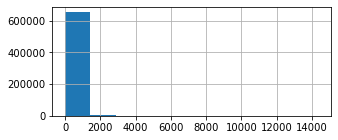

In [3]:
# Original distribution of paytime hours
df.playtime_forever.hist(figsize=(5,2))

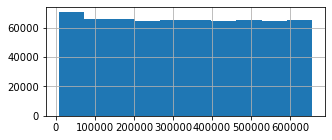

In [4]:
# Taking the rank
df['ranked'] = df.playtime_forever.rank(ascending=1)
df.ranked.hist(figsize=(5,2))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B38C7799E8>]], dtype=object)

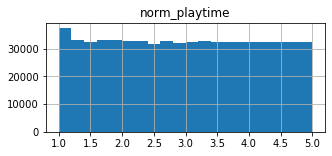

In [5]:
# Rescaling for a more human-friendly 5 point scale
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1, 5))
x = np.array(df.ranked).reshape(-1, 1)
x_scaled = min_max_scaler.fit_transform(x)

dx = pd.DataFrame(x_scaled, columns=['norm_playtime'])
dx.hist(bins=20, figsize=(5,2))

In [6]:
# Create dataframe for collab learner
data = df[['steamid', 'appid']].copy()
data['playtime_index'] = dx['norm_playtime'].values.copy()
data['Title'] = df.Title.copy()

data.sample(5)

,steamid,appid,playtime_index,Title
244905,76561198029409494,219680,1.692082,Proteus
550931,76561197989113204,320,3.014184,Half-Life 2: Deathmatch
355670,76561198065217811,105600,1.831272,Terraria
467691,76561197988650478,113200,2.932864,The Binding of Isaac
513140,76561197971947592,209170,4.891367,Call of Duty®: Ghosts


### 3. Create Databunch and Collaborative filtering Learner
Validation set is contained within the `databunch`.

In [7]:
user, item, title = 'steamid', 'appid', 'Title'

dbn = CollabDataBunch.from_df(data, seed=2, valid_pct=0.1, item_name=title)
dbn.show_batch()

steamid,Title,target
76561198065594715,Dota 2,4.9158998
76561198073442610,Tribes: Ascend,3.7885087
76561197988903378,Garry's Mod,4.831488
76561198000629078,Half-Life 2: Deathmatch,1.2015015
76561198028182814,"Cook, Serve, Delicious!",2.0576851


In [8]:
# Create learner
y_range = [1, 5]
learn = collab_learner(dbn, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.00E-06


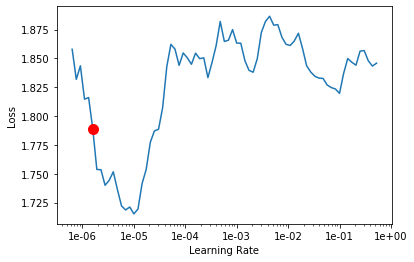

In [11]:
# Find good learning rate from slope
learn.lr_find()
learn.recorder.plot(skip_end=15, suggestion=True)

Results from above give no obvious choice for learning rate, `lr = 0.5` tended to work well in practice.

### 4. Training Collab Model

epoch,train_loss,valid_loss,time
0,1.798863,1.812218,01:47
1,1.846526,1.844597,01:46
2,1.762829,1.790360,01:46
3,1.564668,1.536545,01:47
4,1.008951,1.017531,01:46


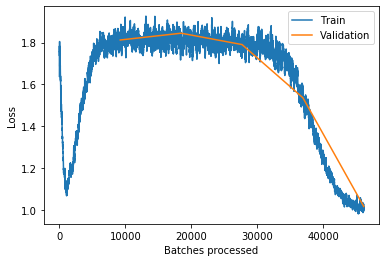

In [12]:
learn.fit_one_cycle(5, 0.5)
learn.recorder.plot_losses()

In [13]:
learn.save('steam-collab')

### 5. EmbeddingNN Collab Model
The EmbeddingNN model builds on the collab model by passing the output of the embedding layers into a tabular NN, with hidden layers of size `[256, 128]`.

In [36]:
learn = collab_learner(dbn, use_nn=True, 
                       emb_szs={'steamid': 40, 'appid':40}, layers=[256, 128], y_range=(1, 5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


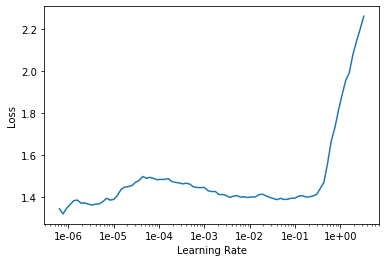

In [16]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,time
0,0.951848,0.953623,02:52
1,0.876612,0.959616,02:46


We can see the validation loss is slightly lower on the `NNModel` (0.959) than the base `Collab Filtering` model (1.017).

In [38]:
learn.save('steam-nn-1')

## 6. Interpreting Results
Extracting the weights and biases from the embedding vectors and visualising the output.

In [87]:
learn.load('steam-collab')
learn.model

# Top games by user base
g = data.groupby(title)['playtime_index'].count()
top_games = g.sort_values(ascending=False).index.values[:1000]
pd.Series(top_games[:10])

0                     Team Fortress 2
1                              Dota 2
2              Counter-Strike: Source
3                       Left 4 Dead 2
4                      Counter-Strike
5    Call of Duty®: Modern Warfare® 2
6                         Alien Swarm
7                         Half-Life 2
8    Counter-Strike: Global Offensive
9         The Elder Scrolls V: Skyrim
dtype: object

In [88]:
# Taking bias from game embeddings
game_bias = learn.bias(top_games, is_item=True)
game_bias.shape

mean_playrank = data.groupby(title)['playtime_index'].mean()
game_playrank = [(b, i, mean_playrank.loc[i]) for i,b in zip(top_games, game_bias)]
item0 = lambda o:o[0]

sorted(game_playrank, key=item0)[:10]

[(tensor(-1.5136), 'Ricochet', 1.287013570560249),
 (tensor(-1.3854), 'Deathmatch Classic', 1.508928271096006),
 (tensor(-1.3468), 'Defence Alliance 2', 1.4746217027507067),
 (tensor(-1.3026), 'Arma 2: Private Military Company', 1.2213934520927674),
 (tensor(-1.2911), 'Half-Life 2: Lost Coast', 1.7633229074886818),
 (tensor(-1.2621), 'Arma 2: British Armed Forces', 1.2148520324639986),
 (tensor(-1.1005), 'Half-Life Deathmatch: Source', 1.5488544201331071),
 (tensor(-1.0581), 'Grand Theft Auto', 1.367887523588553),
 (tensor(-1.0375),
  'GTR Evolution Expansion Pack for RACE 07',
  1.2700206348265324),
 (tensor(-0.9710), 'Arma II: DayZ Mod', 1.8742219967741691)]

The sorted bias vector appears to describes games that have a lot of players, but not many playing hours. 
* `Ricochet` and `Deathmatch Classic` are part of the bundle Valve Complete Pack.
* `Defence Alliance 2` is a free game. 
* `Half-Life 2: Lost Coast` is a popular but short DLC expansion.

The other end of this vector shows popular games with dedicated users.

In [89]:
sorted(game_playrank, key=lambda o: o[0], reverse=True)[:10]

[(tensor(1.1508), 'The Elder Scrolls V: Skyrim', 4.157446401359691),
 (tensor(0.9217), 'DARK SOULS™ II', 4.149527243424506),
 (tensor(0.9173), "Sid Meier's Civilization® V", 3.9999630471564607),
 (tensor(0.8710), 'Borderlands 2', 3.924718121163953),
 (tensor(0.8346), 'Total War™: ROME II - Emperor Edition', 4.009788679032362),
 (tensor(0.8025), 'XCOM: Enemy Unknown', 3.913870411408909),
 (tensor(0.7911), 'Counter-Strike: Global Offensive', 3.858883671655006),
 (tensor(0.7890), 'Starbound', 3.842402882274578),
 (tensor(0.7713), 'Arma 3', 3.89116440093489),
 (tensor(0.7576), 'Assassin’s Creed® IV Black Flag™', 4.072294045056885)]

The embedding vector `40` parameters long for both games and users, so we use `PCA` to simplify them down to just 3 vectors, of which we can visualise (X, Y).

PCA matrix: torch.Size([1000, 3])
Choosing 2 out of 3 vectors to plot..


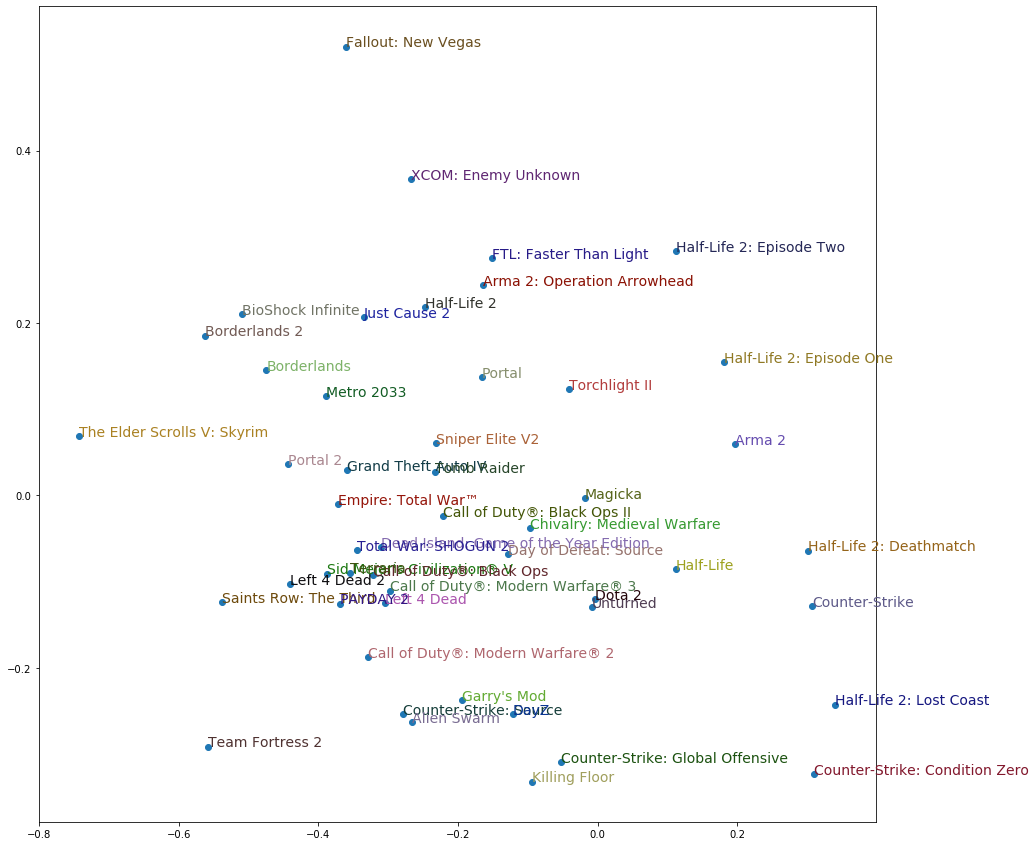

In [90]:
# Game weights
games_w = learn.weight(top_games, is_item=True)

# PCA
games_pca = games_w.pca(3)
print(f'PCA matrix: {games_pca.shape}')
fac0, fac1, fac2 = games_pca.t()

# Scatter plot of top 50 games
idxs = np.random.choice(len(top_games), 50, replace=False)
idxs = list(range(50))

print('Choosing 2 out of 3 vectors to plot..')
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_games[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

### 7. Making Predictions
Example predictions and loss from validation set.

In [91]:
# Extract validation sample from databunch
(users, items), ratings = next(iter(dbn.valid_dl))
preds = learn.model(users.cpu(), items.cpu())

out = dbn.valid_ds.inner_df.head(10).copy().reset_index(drop=True)
out['prediction'] = pd.Series(preds[:10])
out['difference'] = out['prediction'] - out['playtime_index']
out = pd.concat([out[['steamid', 'appid', 'Title']],
                 out[['playtime_index', 'prediction', 'difference']]], axis=1)
display(out)

,steamid,appid,Title,playtime_index,prediction,difference
0,76561197972414722,730,Counter-Strike: Global Offensive,3.213209,3.715842,0.502633
1,76561197971862984,12220,Grand Theft Auto: Episodes from Liberty City,3.233757,3.177073,-0.056684
2,76561198073830318,291480,Warface,1.674882,2.562165,0.887284
3,76561197973393854,16450,F.E.A.R. 2: Project Origin,2.097469,2.791708,0.694239
4,76561197973687048,42700,Call of Duty®: Black Ops,1.233028,3.552752,2.319724
5,76561198029372260,91310,Dead Island: Game of the Year Edition,3.699872,3.351510,-0.348362
6,76561198065381441,257730,Infinity Wars: Animated Trading Card Game,1.322789,2.921527,1.598737
7,76561197971948144,280,Half-Life: Source,2.189450,2.457155,0.267705
8,76561198065010727,570,Dota 2,1.233028,3.746202,2.513173
9,76561198076700923,15620,"Warhammer® 40,000™: Dawn of War® II",1.872207,3.161341,1.289134
